# Модули, настройки, функции

In [1]:
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from pandas import Series

from datetime import datetime, timedelta
import itertools
import ast
from itertools import combinations
from scipy.stats import ttest_ind, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

from wordcloud import WordCloud, STOPWORDS 
import string
import re
import nltk
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

import json

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")

Функции:

In [3]:
# Вычисление метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


# Преобразование в None для строковых признаков
def set_None(value):
    if value is None:
        return value
    else:        
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan' or str_value.lower() == 'none':
            return None
        else:
            return str_value


# перевод в нижний регистр
def set_lower(value):
    if value is None:
        return value
    else:
        return value.lower()
    
    
# Определение выбросов
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col], Q1 - 1.5*IQR, Q3 + 1.5*IQR


# Информация о выбросах с графиками
def show_info(df, col, show=True):
    # Выводим количество выбросов и их границы
    out, lim1, lim2 = get_outlier(df, col)
    minCol = df[col].min()
    maxCol = df[col].max()
    median = df[col].median()
    nulCol = sum(pd.isnull(df[col]))
    
    cnt = min(int(df[col].value_counts().count()),2000)
    
    if show:
        print('Не заполнено: ', nulCol)
        print('Минимум: ', minCol)
        print('Максимум: ', maxCol)
        print('Медиана: ', median)
        print('Количество выбросов: ', len(out))
        if len(out) > 0:
            print('Нижняя граница выбросов: ', lim1)
            print('Верхняя граница выбросов: ', lim2)

        # Выводим графики: гистограмму и боксплот
        fig, axes = plt.subplots(1,2,figsize=(12,4))
        axes[0].hist(df[col], bins=cnt)
        axes[1].boxplot(df[col])
    
    return {'med': median, 'lm1': lim1, 'lm2': lim2}


# График с боксплотами
def show_boxplot(df, x_col, y_col):
    plt.figure(figsize=(12, 8))
    g = sns.boxplot(y=y_col, x=x_col, data=df, color='yellow')
    g.set_title(y_col + ' of ' + x_col, fontsize=20)
    g.set_ylabel(y_col, fontsize=15)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    plt.show()
    
# Сравнение двух графиков 
def val_log_plot(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].hist(df[col], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(col)

    ax[1].hist(np.log(df[col]+1), rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of '+col)

    plt.show()
    

            
# функция вычисления попарного p_value при множественном значении категориального столбца
def get_stat_dif(df, columns, col_target):
    
    p_list =[]
    res = '' 
    for col in columns:
        cols = df.loc[:, col].value_counts().index
        combinations_all = list(combinations(cols, 2))
        if len(combinations_all)==0:
            res = col + ': значимости нет'
            print(res)
            continue
        
        conv = 0.05 / len(combinations_all) # пороговый уровень значимости с поправкой Бонферрони
    
        for comb in combinations_all:
            p_value = ttest_ind(df.loc[df.loc[:, col] == comb[0], col_target], 
                     df.loc[df.loc[:, col] == comb[1], col_target]).pvalue
            p_list.append(p_value)
        
            if p_value < conv:
                res = ', значимость есть: для ' + str(comb) + ' p_value=' + str(p_value)
            else:
                res = ', значимости нет'
            break
            
        if res == '':
            res = ', значимости нет: min(p_value)=' + str(min(p_list))
    
        res = col + ': порог=' + str(round(conv,6)) + res
        print(res)
        
        
def get_stat_corr(df, columns, col_target):
    
    for col in columns:
        p_value = pearsonr(df[col], df[col_target])[1]
    
        if (p_value / len(columns)) < 0.05:
            print(col + ' для ' + col_target + ' - значимость есть')
        else:
            print(col + ' для ' + col_target + ' - значимости нет')
        

In [4]:
RANDOM_SEED = 42
VAL_SAZE = 0.15

# Чтение данных

In [5]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [7]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [9]:
test.nunique()

bodyType                  14
brand                      3
color                     15
description             1540
engineDisplacement        43
enginePower              120
fuelType                   4
mileage                  935
modelDate                 37
model_info               101
name                     536
numberOfDoors              4
productionDate            35
sell_id                 1671
vehicleConfiguration     205
vehicleTransmission        4
Владельцы                  3
Владение                 131
ПТС                        2
Привод                     3
Руль                       1
dtype: int64

In [10]:
# Для быстрой обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 
test['sample'] = 0 
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

df = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, df.shape)

(6682, 23) (1671, 23) (8353, 23)


# EDA

Каждый признак рассмотрим и обработаем отдельно.

### price

In [11]:
df[df['sample']==1].price.min(), df[df['sample']==1].price.max()

(301301.0, 23900000.0)

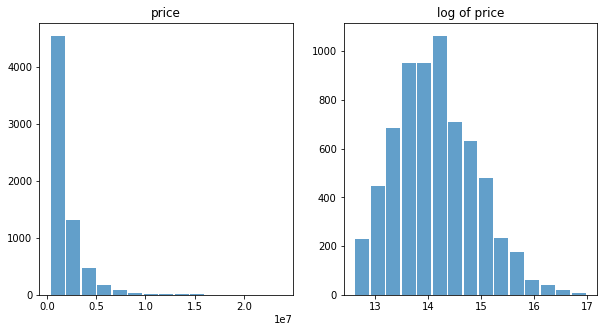

In [12]:
# Наглядное влияние логарифма
val_log_plot(df[df['sample']==1], 'price')

In [13]:
# Введем еще одну переменную - логарифм цены для проверки на ней значимости признаков
df['price_log'] = np.log(df['price']+1)

### model_info

In [14]:
display(train['model_info'].unique()[:10])
display(test['model_info'].unique()[:10])

array(['5ER', 'A6', 'E_KLASSE', 'A5', 'C_KLASSE', '7ER', '3ER', 'X4',
       'M_KLASSE', 'S_KLASSE_AMG'], dtype=object)

array(['W124', '6ER', '3ER', '5ER', 'Q7', 'SL_KLASSE', 'A5', 'A4',
       'GL_KLASSE', 'A6'], dtype=object)

In [15]:
df.model_info.unique(), len(df.model_info.unique())

(array(['W124', '6ER', '3ER', '5ER', 'Q7', 'SL_KLASSE', 'A5', 'A4',
        'GL_KLASSE', 'A6', '1ER', 'X5', 'X3', 'S_KLASSE',
        'S_CLASS_MAYBACH', 'G_KLASSE', 'E_KLASSE', 'X7', 'Q5', 'A3',
        'B_KLASSE', '4', 'CLS_KLASSE_AMG', 'RS3', 'X6', 'C_KLASSE', 'X1',
        'S8', 'Q3', 'X6_M', '7ER', 'GLS_KLASSE', 'A7', 'GLC_KLASSE', 'TT',
        'Q8', 'M3', 'M4', 'C_KLASSE_AMG', 'X4', 'G_KLASSE_AMG', 'VITO',
        'M_KLASSE', 'CLA_KLASSE', 'TTS', 'GLK_KLASSE', 'SLK_KLASSE_AMG',
        'CLS_KLASSE', 'R_KLASSE', 'S_KLASSE_AMG', 'VIANO', 'GLE_KLASSE',
        'S5', 'AMG_GT', 'A8', 'M_KLASSE_AMG', 'A_KLASSE', 'M5', 'X5_M',
        'GLE_KLASSE_COUPE_AMG', 'ALLROAD', 'GLE_KLASSE_COUPE',
        'E_KLASSE_AMG', 'GLA_CLASS', 'SLS_AMG', 'AMG_GLC_COUPE',
        'V_KLASSE', 'GLE_KLASSE_AMG', 'X2', 'A4_ALLROAD', 'CL_KLASSE',
        'SLK_KLASSE', 'CLA_KLASSE_AMG', 'RS5', 'X_KLASSE', 'W123', 'A1',
        'S6', 'M6', 'M1', '2ER', '8ER', 'RS6', 'SL_KLASSE_AMG', 'S7', 'M2',
        'CL_KLASSE

In [16]:
df.model_info = df.model_info.apply(set_None)

In [17]:
df[df.model_info.isnull()].shape

(1, 24)

In [18]:
# Строка с отстутсвующей моделью всего одна. Заполним модель по названию автомобиля.
nm = df[df.model_info.isnull()].iloc[0]['name']
m_i = df[df['name']==nm].iloc[0].model_info
df.model_info = df.model_info.fillna(m_i)

### bodyType

In [19]:
display(df['bodyType'].value_counts())

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

In [20]:
df['bodyType'].unique()

array(['универсал 5 дв.', 'купе', 'седан', 'внедорожник 5 дв.', 'родстер',
       'лифтбек', 'хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе-хардтоп',
       'внедорожник 3 дв.', 'минивэн', 'кабриолет',
       'пикап двойная кабина', 'внедорожник открытый', 'компактвэн',
       'седан 2 дв.', 'лимузин'], dtype=object)

In [21]:
# Выделим крупные группы кузовов. Для этого возьмем первые слова в их названиях

def get_body(value):
    if value is None:
        return value
    else:
        main_value = str(value).strip().split()[0].split('-')[0]
        return main_value

    
df['body'] = df['bodyType'].apply(get_body)
df['body'].unique()

array(['универсал', 'купе', 'седан', 'внедорожник', 'родстер', 'лифтбек',
       'хэтчбек', 'минивэн', 'кабриолет', 'пикап', 'компактвэн',
       'лимузин'], dtype=object)

### brand

In [22]:
print(df['brand'].unique())

['MERCEDES' 'BMW' 'AUDI']


### color

In [23]:
print(df['color'].unique())

['чёрный' 'белый' 'пурпурный' 'синий' 'коричневый' 'серый' 'зелёный'
 'серебристый' 'красный' 'оранжевый' 'голубой' 'фиолетовый' 'бежевый'
 'жёлтый' 'золотистый' 'розовый']


In [24]:
df['color'].value_counts()

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

In [25]:
# Сделаем признак популярности цвета
# color_rare = ['жёлтый', 'оранжевый', 'пурпурный', 'фиолетовый', 'розовый']
color_freq = ['чёрный', 'белый',  'серый', 'синий']
# df['color_type'] = df['color'].apply(lambda x: 0 if x in color_freq else 2 if x in color_rare else 1)
df['color_type'] = df['color'].apply(lambda x: 0 if x in color_freq else 1)
df['color_type'].value_counts()

0    6863
1    1490
Name: color_type, dtype: int64

Посмотрим на влияние цвета на цену

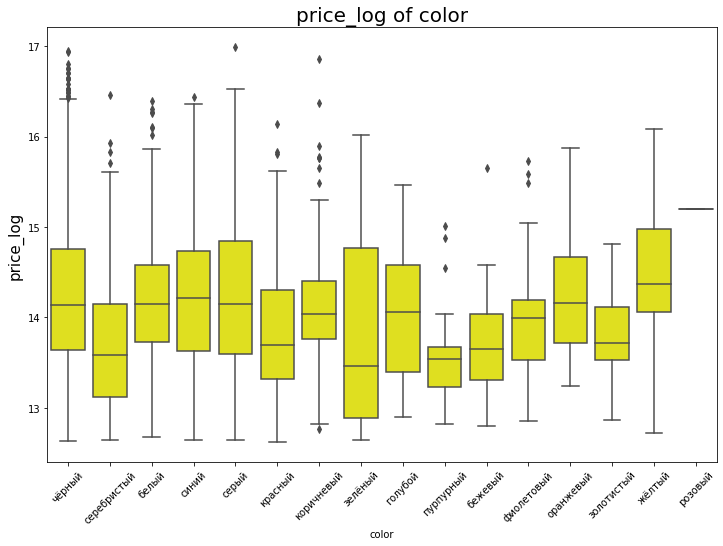

In [26]:
show_boxplot(df[df['sample']==1], 'color', 'price_log')

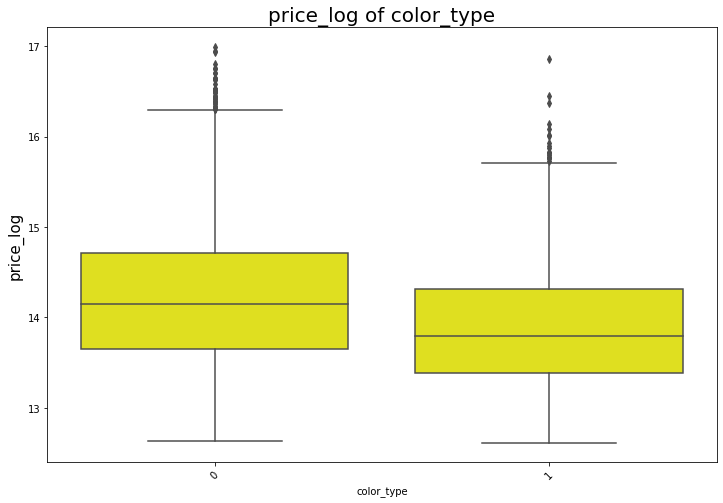

In [27]:
show_boxplot(df[df['sample']==1], 'color_type', 'price_log')

### enginePower

In [28]:
df.enginePower.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

In [29]:
df['enginePower'] = df['enginePower'].apply(lambda x: str(x).split()[0])
df['enginePower'] = df['enginePower'].apply(lambda x: int(x))

In [30]:
# Добавим столбец с налоговой ставкой на мощность автомобиля
bins = [0, 100, 125, 150, 175, 200, 225, 250, 801]
labels = ['12','25','35', '45', '50', '65', '75', '150']
df['tax_rate'] = pd.cut(df['enginePower'], bins=bins, labels=labels)
df['tax_rate'] = df['tax_rate'].values.astype('int64')

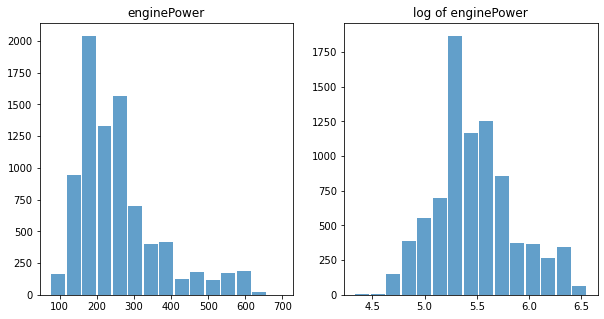

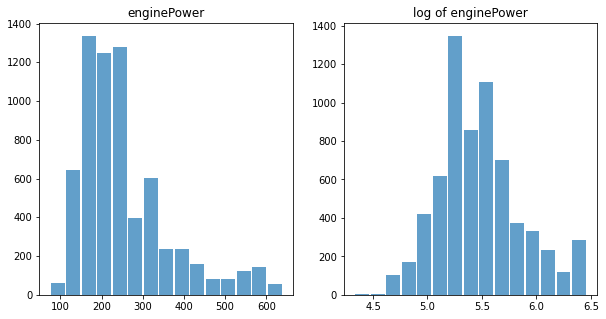

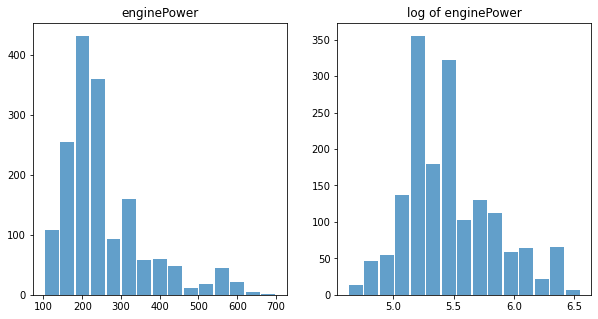

In [31]:
# Посмотрим на влияние логарифма
val_log_plot(df, 'enginePower')
val_log_plot(df[df['sample']==1], 'enginePower')
val_log_plot(df[df['sample']==0], 'enginePower')

In [32]:
# Распределение улучшилось. Добавим столбец с логарифмом.
df['eP_log'] = np.log(df['enginePower'] + 1)

Не заполнено:  0
Минимум:  4.624972813284271
Максимум:  6.55250788703459
Медиана:  5.44673737166631
Количество выбросов:  1
Нижняя граница выбросов:  4.470355825078324
Верхняя граница выбросов:  6.476847747587197


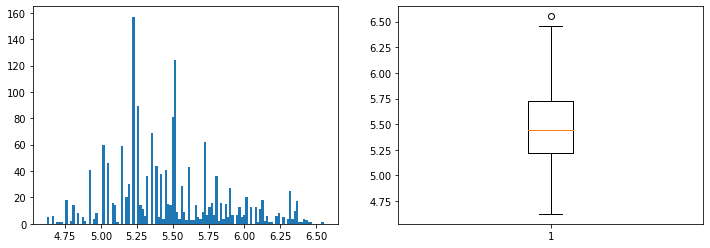

In [33]:
# Проверим наличие выбросов
d = show_info(df[df['sample']==0],'eP_log')

Не заполнено:  0
Минимум:  4.330733340286331
Максимум:  6.461468176353717
Медиана:  5.44673737166631
Количество выбросов:  6
Нижняя граница выбросов:  4.470355825078324
Верхняя граница выбросов:  6.476847747587197


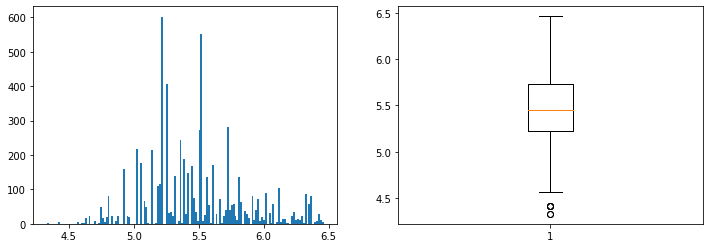

In [34]:
d = show_info(df[df['sample']==1],'eP_log')

Выбросов мало. Ничего с ними делать не будем, только пометим строки с выбросами.

In [35]:
# Делаем столбец с пометкой выбросов. Объединяем, так как границы выбросов совпадают.
d = show_info(df,'eP_log', show=False)
df['eP_log_out'] = df['eP_log'].apply(lambda x: 1 if x>d['lm2'] or x<d['lm1'] else 0)

### engineDisplacement

In [36]:
df.engineDisplacement.unique()

array(['3.0 LTR', '2.5 LTR', '2.0 LTR', '3.5 LTR', '1.8 LTR', '2.2 LTR',
       '5.5 LTR', '4.8 LTR', '1.6 LTR', '4.7 LTR', '4.0 LTR', '1.5 LTR',
       '2.4 LTR', '1.4 LTR', '2.1 LTR', '5.2 LTR', '4.4 LTR', '2.8 LTR',
       '4.2 LTR', '3.2 LTR', '6.0 LTR', '3.7 LTR', '5.0 LTR', '1.2 LTR',
       '3.6 LTR', '2.3 LTR', '6.2 LTR', '1.7 LTR', '1.3 LTR', '5.4 LTR',
       '3.1 LTR', '2.6 LTR', '3.8 LTR', '4.1 LTR', '2.9 LTR', '6.6 LTR',
       '5.9 LTR', 'undefined LTR', '2.7 LTR', '0.7 LTR', '1.9 LTR',
       '4.3 LTR', '5.8 LTR', '4.9 LTR', '3.4 LTR', '6.3 LTR', '5.6 LTR',
       '4.6 LTR'], dtype=object)

In [37]:
df[df.engineDisplacement=='undefined LTR'].fuelType.unique()

array(['электро'], dtype=object)

Все автомобили, у которых неизвестен объем двигателя, - электрические. Заменим у электроавтомобилей объем двигателя на значение от мощности, разделив на 70. Это грубое приближение, но оно лучше медианы от всех машин.

In [38]:
df[df.engineDisplacement=='undefined LTR'] = df[df.engineDisplacement=='undefined LTR'].apply(lambda x: x.replace('undefined LTR', '0.0 '))
df.engineDisplacement = df.engineDisplacement.apply(lambda x: x[:3])
df.engineDisplacement = df.engineDisplacement.apply(lambda x: float(x))

df.engineDisplacement = df.apply(lambda row: row['engineDisplacement'] if row['engineDisplacement']>0 \
                                          else np.round(row['enginePower']/70, 1), axis=1)

In [39]:
df.engineDisplacement.unique()

array([3. , 2.5, 2. , 3.5, 1.8, 2.2, 5.5, 4.8, 1.6, 4.7, 4. , 1.5, 2.4,
       1.4, 2.1, 5.2, 4.4, 2.8, 4.2, 3.2, 6. , 3.7, 5. , 1.2, 3.6, 2.3,
       6.2, 1.7, 1.3, 5.4, 3.1, 2.6, 3.8, 4.1, 2.9, 6.6, 5.9, 2.7, 0.7,
       1.9, 4.3, 5.8, 4.9, 3.4, 6.3, 5.6, 4.6])

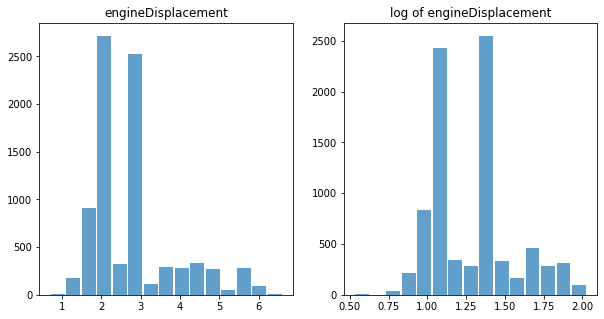

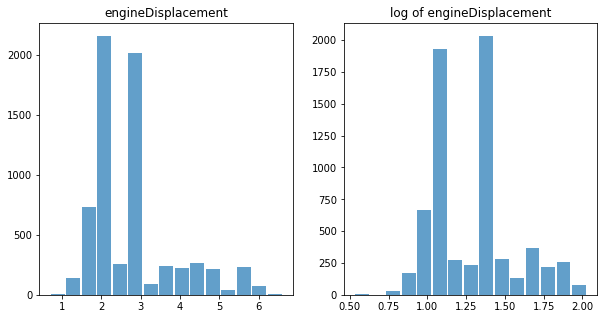

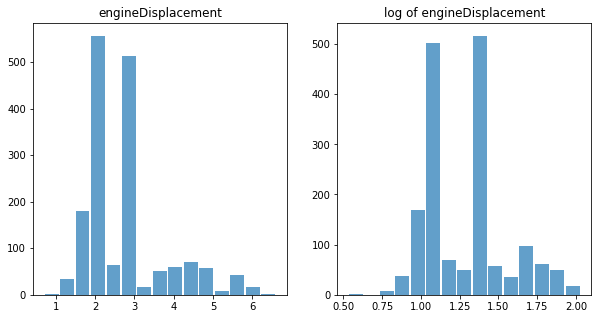

In [40]:
# Посмотрим на влияние логарифма
val_log_plot(df, 'engineDisplacement')
val_log_plot(df[df['sample']==1], 'engineDisplacement')
val_log_plot(df[df['sample']==0], 'engineDisplacement')

Распределение стало на мизер лучше - пик сместился ближе к центру. Прологарифмируем, так как это дополнительно уменьшит количество выбросов.

In [41]:
# Логарифмируем
df['eD_log'] = np.log(df['engineDisplacement'] + 1)

Не заполнено:  0
Минимум:  0.7
Максимум:  6.6
Медиана:  2.8
Количество выбросов:  565
Нижняя граница выбросов:  0.5
Верхняя граница выбросов:  4.5


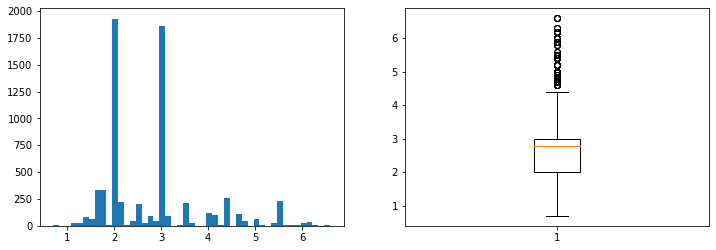

In [42]:
# Выбросы
d = show_info(df[df['sample']==1],'engineDisplacement')

Не заполнено:  0
Минимум:  0.5306282510621704
Максимум:  2.028148247292285
Медиана:  1.33500106673234
Количество выбросов:  343
Нижняя граница выбросов:  0.6486122886681098
Верхняя граница выбросов:  1.8362943611198905


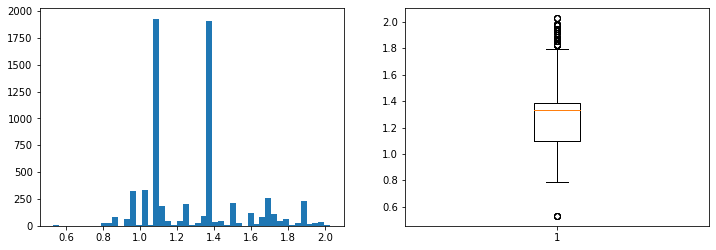

In [43]:
d = show_info(df[df['sample']==1],'eD_log')

Не заполнено:  0
Минимум:  0.7
Максимум:  6.6
Медиана:  2.7
Количество выбросов:  128
Нижняя граница выбросов:  0.5
Верхняя граница выбросов:  4.5


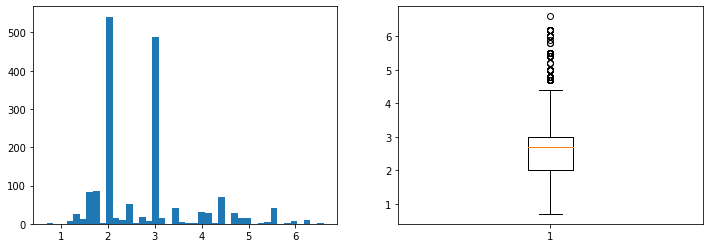

In [44]:
d = show_info(df[df['sample']==0],'engineDisplacement')

Не заполнено:  0
Минимум:  0.5306282510621704
Максимум:  2.028148247292285
Медиана:  1.308332819650179
Количество выбросов:  68
Нижняя граница выбросов:  0.6486122886681098
Верхняя граница выбросов:  1.8362943611198905


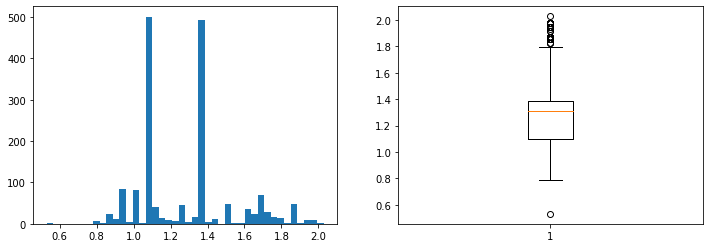

In [45]:
d = show_info(df[df['sample']==0],'eD_log')

In [46]:
# Делаем столбец с пометкой выбросов. Объединяем, так как границы выбросов совпадают.
d = show_info(df,'eD_log', show=False)
df['eD_log_out'] = df['eD_log'].apply(lambda x: 1 if x>d['lm2'] or x<d['lm1'] else 0)

### fuelType

In [47]:
df.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро'], dtype=object)

### Привод

In [48]:
df.Привод.unique()

array(['задний', 'полный', 'передний'], dtype=object)

### numberOfDoors

In [49]:
df.numberOfDoors.unique()

array([5, 2, 4, 3])

### ПТС

In [50]:
df.ПТС.unique()

array(['Оригинал', 'Дубликат'], dtype=object)

In [51]:
# Сделаем двоичный признак
pts_dict={'Оригинал': 0, 'Дубликат': 1}
df['ПТС'] = df['ПТС'].map(pts_dict)

### Руль

In [52]:
df.Руль.unique()

array(['Левый', 'Правый'], dtype=object)

In [53]:
# Сделаем двоичный признак
rule_dict={'Левый': 0, 'Правый': 1}
df['Руль'] = df['Руль'].map(rule_dict)

### vehicleTransmission

In [54]:
df.vehicleTransmission.unique()

array(['автоматическая', 'вариатор', 'роботизированная', 'механическая'],
      dtype=object)

In [55]:
# Приведем названия к более коротким
tr_dict={'автоматическая': 'AT','механическая': 'MT','роботизированная': 'RBT', 'вариатор': 'VRT'}
df['vehicleTransmission'] = df['vehicleTransmission'].map(tr_dict)

### vehicleConfiguration

In [56]:
print(df.vehicleConfiguration[4660:4680])

4660              SEDAN AUTOMATIC 5.5
4661               SEDAN VARIATOR 2.0
4662    ALLROAD_5_DOORS AUTOMATIC 2.0
4663    ALLROAD_5_DOORS AUTOMATIC 3.5
4664               LIFTBACK ROBOT 2.0
4665    ALLROAD_5_DOORS AUTOMATIC 2.9
4666              SEDAN AUTOMATIC 5.0
4667              SEDAN AUTOMATIC 3.0
4668              SEDAN AUTOMATIC 2.5
4669    ALLROAD_5_DOORS AUTOMATIC 2.0
4670              COUPE AUTOMATIC 5.4
4671               LIFTBACK ROBOT 2.0
4672       ALLROAD_OPEN AUTOMATIC 5.0
4673              SEDAN AUTOMATIC 1.8
4674              COUPE AUTOMATIC 4.0
4675              SEDAN AUTOMATIC 3.0
4676              SEDAN AUTOMATIC 2.0
4677              SEDAN AUTOMATIC 2.0
4678               SEDAN VARIATOR 2.8
4679              SEDAN AUTOMATIC 3.0
Name: vehicleConfiguration, dtype: object


Столбец содержит данные, которые есть в других столбцах. использовать его не будем.

### mileage

<AxesSubplot:>

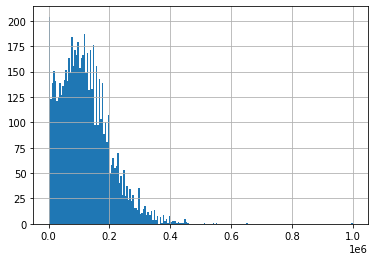

In [57]:
df[df['sample']==1].mileage.hist(bins=200)

<AxesSubplot:>

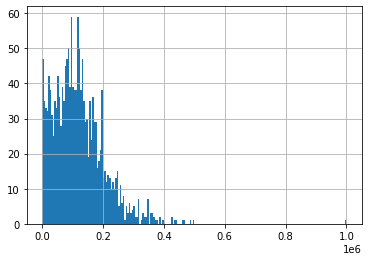

In [58]:
df[df['sample']==0].mileage.hist(bins=200)

Не заполнено:  0
Минимум:  1
Максимум:  1000000
Медиана:  109000.0
Количество выбросов:  37
Нижняя граница выбросов:  -99630.75
Верхняя граница выбросов:  324379.25


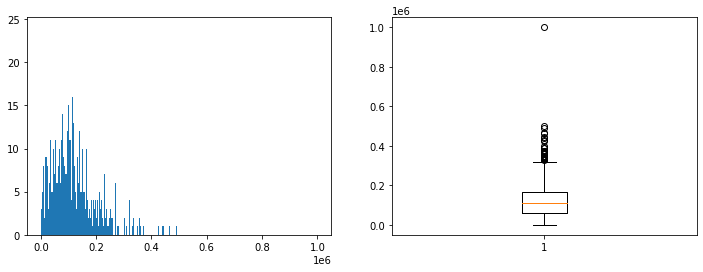

In [59]:
# Проверим выбросы
d = show_info(df[df['sample']==0],'mileage')

Не заполнено:  0
Минимум:  1
Максимум:  999999
Медиана:  111000.0
Количество выбросов:  113
Нижняя граница выбросов:  -103953.75
Верхняя граница выбросов:  331172.25


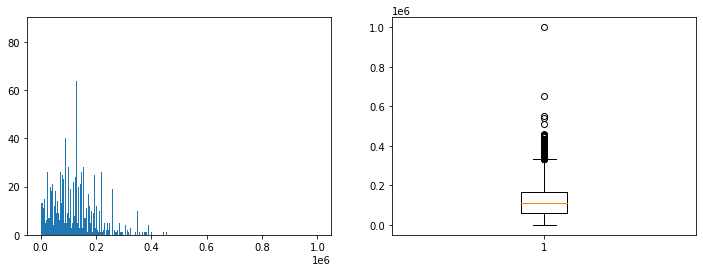

In [60]:
d = show_info(df[df['sample']==1],'mileage')

In [61]:
# Делаем столбец с пометкой выбросов. Объединяем, так как границы выбросов практически совпадают.
d = show_info(df,'mileage', show=False)
df['mileage_out'] = df['mileage'].apply(lambda x: 1 if x>d['lm2'] else 0)

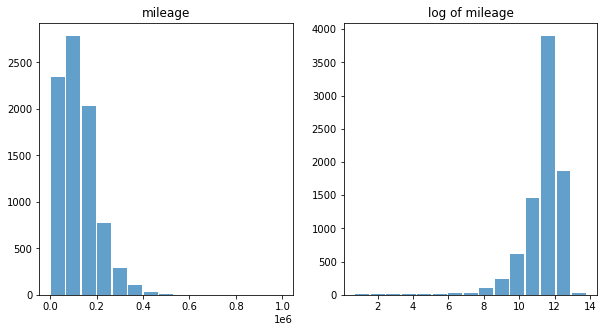

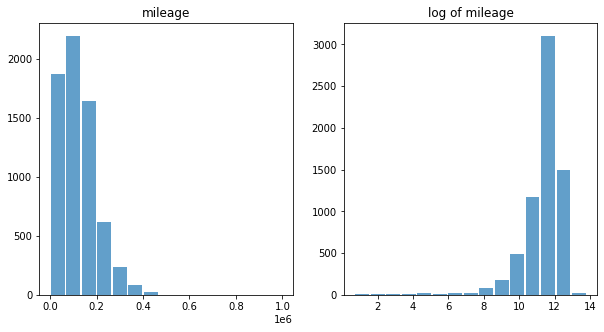

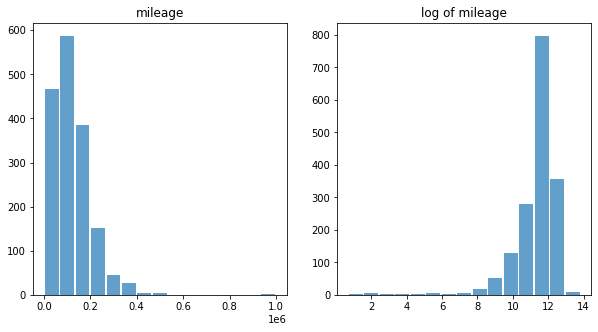

In [62]:
# Посмотрим на влияние логарифма
val_log_plot(df, 'mileage')
val_log_plot(df[df['sample']==1], 'mileage')
val_log_plot(df[df['sample']==0], 'mileage')

Распределение лучше не стало, к тому же опытным путем было выяснено, что логарифмирование значительно увеличивает количество выбросов.    
Вместо логарифмирования просто отнормируем.

In [63]:
# Статистики у train и test примерно совпадают, поэтому преобразовываем объединенный датасет
m = df['mileage'].mean()
df['mileage_norm'] = df['mileage']/m

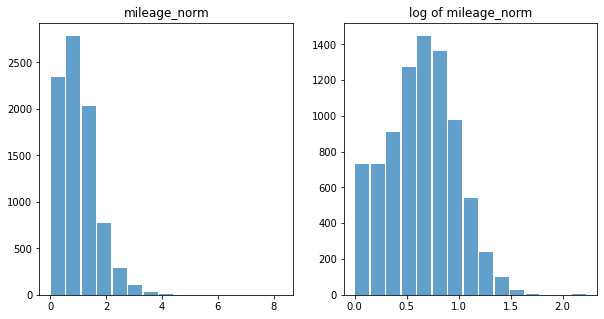

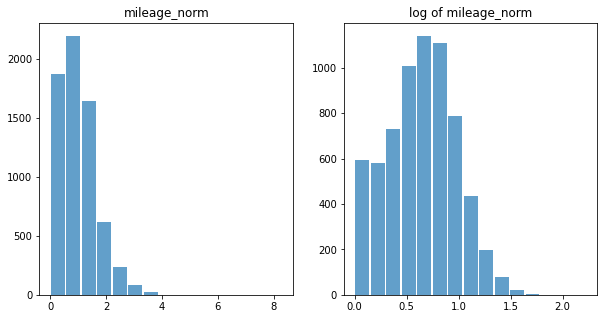

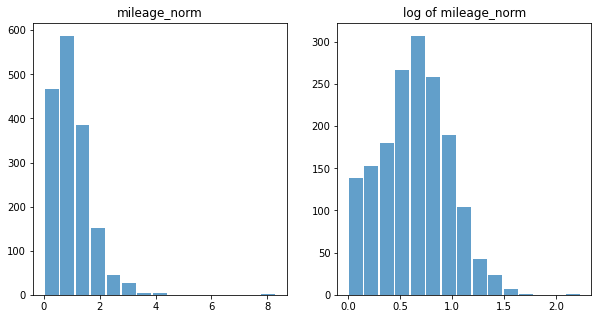

In [64]:
val_log_plot(df, 'mileage_norm')
val_log_plot(df[df['sample']==1], 'mileage_norm')
val_log_plot(df[df['sample']==0], 'mileage_norm')

Распределение логарифма от нормированной величины более похоже на нормальное.

In [65]:
# Логарифмируем
df['mileage_norm_log'] = np.log(df['mileage_norm'] + 1)

<AxesSubplot:>

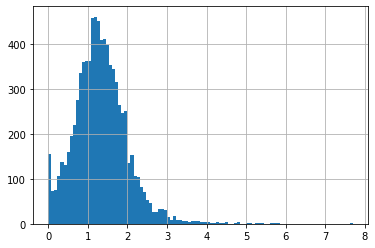

In [66]:
# Введем признак износа - сколько десятков тысяч километров в год проезжала машина
df['milPerYear'] = df.apply(
    lambda row : 0 if row['productionDate']>2020 else row['mileage']/((2021-row['productionDate'])*10000), axis = 1)

df['milPerYear'].hist(bins=100)

### modelDate

In [67]:
df.modelDate.unique()

array([1984, 2011, 2005, 2016, 2009, 2008, 2007, 1989, 2001, 2006, 2013,
       2014, 2015, 2004, 2017, 2018, 2012, 2003, 2019, 2010, 2000, 1990,
       2002, 1998, 1993, 1994, 1999, 1995, 1971, 1996, 1985, 1975, 1992,
       1997, 1987, 1979, 1991, 1982, 1986, 1988, 1981, 1977, 1976])

<AxesSubplot:>

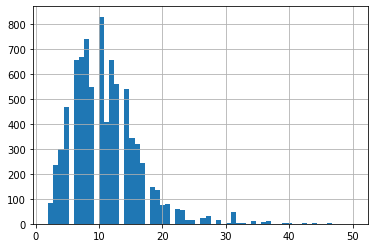

In [68]:
# Новый столбец с возрастом модели автомобиля, чтобы уменьшить значения
df['model_age'] = df['modelDate'].apply(lambda x: 2021-x)
df['model_age'].hist(bins=60)

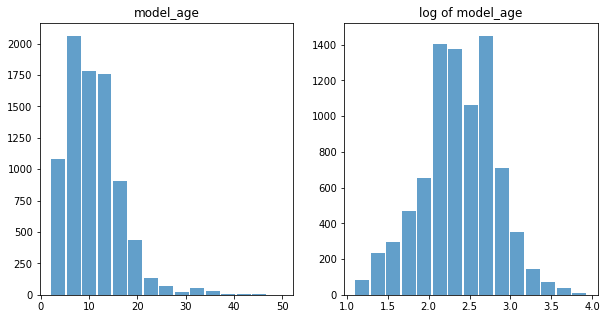

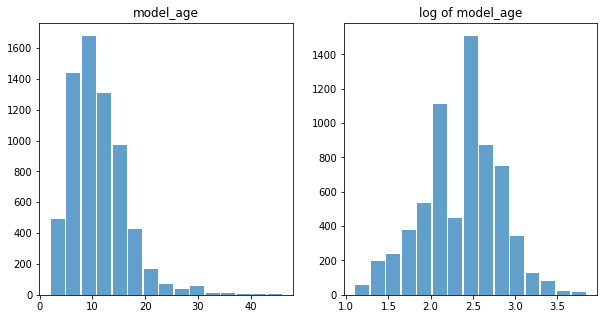

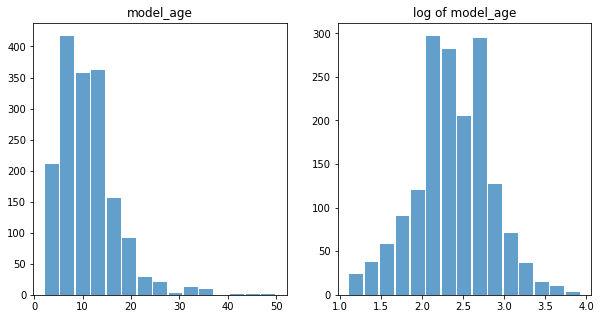

In [69]:
val_log_plot(df, 'model_age')
val_log_plot(df[df['sample']==1], 'model_age')
val_log_plot(df[df['sample']==0], 'model_age')

In [70]:
# Новый столбец с логарифмом 
df['model_age_log'] = np.log(df['model_age'] + 1)

### productionDate

In [71]:
df.productionDate.unique()

array([1991, 2013, 2008, 2007, 2019, 2017, 2014, 2004, 2012, 2011, 2016,
       2010, 2015, 2005, 2018, 2009, 2006, 2020, 2002, 1995, 2000, 1997,
       1994, 1996, 2003, 1992, 2001, 1999, 1984, 1993, 1998, 1986, 1982,
       1990, 1985, 1988, 1987, 1983, 1989])

In [72]:
# Новый столбец с возрастом автомобиля, чтобы уменьшить значения
df['age'] = df['productionDate'].apply(lambda x: 2021-x)

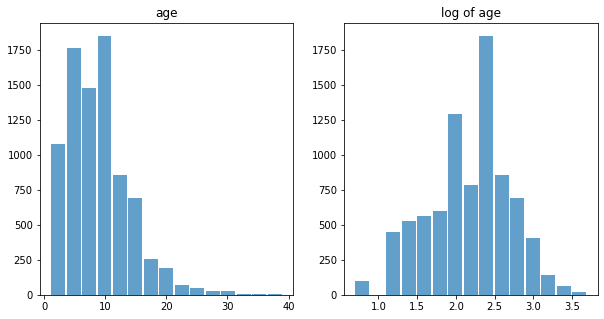

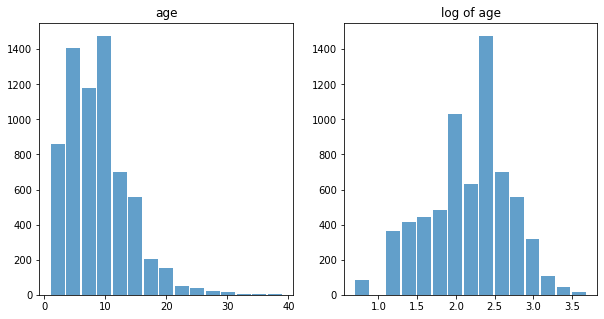

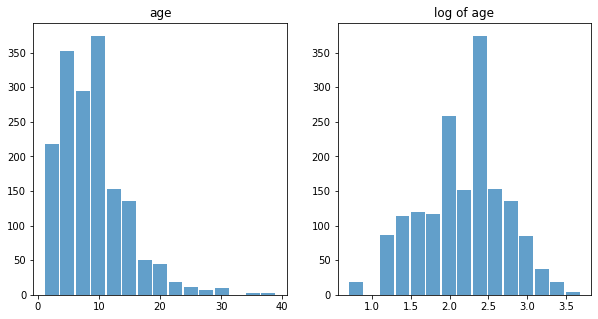

In [73]:
# Посмотрим на влияние логарифма
val_log_plot(df, 'age')
val_log_plot(df[df['sample']==1], 'age')
val_log_plot(df[df['sample']==0], 'age')

In [74]:
# Новый столбец с логарифмом 
df['age_log'] = np.log(df['age'] + 1)

In [75]:
# Новый столбец с разницей между годом выпуска и годом модели
df['model_old'] = df['productionDate'] - df['modelDate']
print(df['model_old'].unique())

[ 7  2  3  1  4  0  6  5  8 13  9 11 12 15 10 18 14 16]


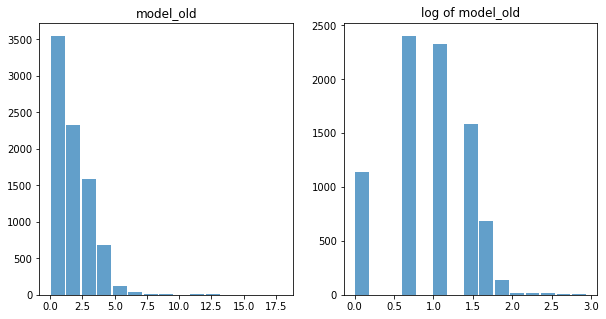

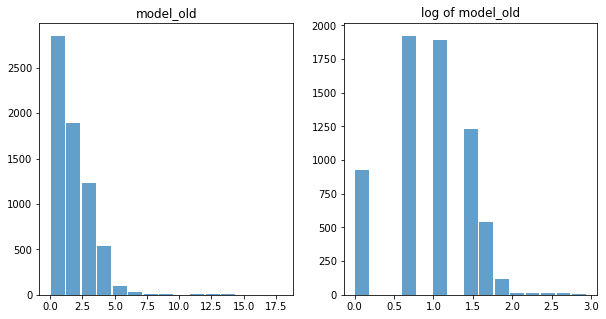

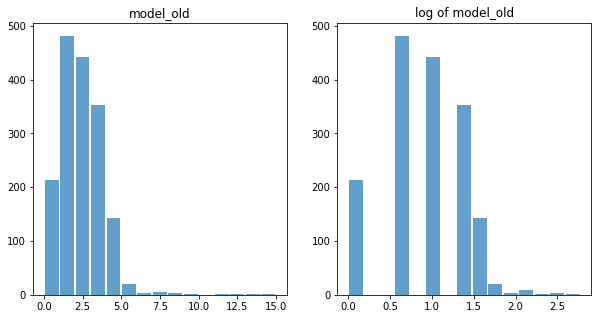

In [76]:
# Посмотрим на влияние логарифма 
val_log_plot(df, 'model_old')
val_log_plot(df[df['sample']==1], 'model_old')
val_log_plot(df[df['sample']==0], 'model_old')

In [77]:
# Логарифмирование улучшило распределение. Создадим столбец с логарифмом.
df['model_old_log'] = np.log(df['model_old']+1)

### Владельцы

In [78]:
df.Владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца', nan],
      dtype=object)

In [79]:
# Поставим примерное количество владельцев в зависимости от возраста машины 
df.Владельцы = df.Владельцы.apply(set_None)
df.Владельцы = df.apply(lambda row: row['Владельцы'] if not(row['Владельцы'] is None) \
                                  else '1' if row['modelDate']>2014 \
                                  else '2' if row['modelDate']>2007 \
                                  else '3' , axis=1)

In [80]:
# Приведем к целым значениям
df['Владельцы'] = df['Владельцы'].apply(lambda x: 3 if '3' in x else 2 if '2' in x else 1 if '1' in x else 0)

In [81]:
df.Владельцы.unique()

array([3, 1, 2])

### Владение

In [82]:
print(df.Владение.unique())

['6 лет и 3 месяца' '6 лет и 6 месяцев' nan '3 года' '2 года и 2 месяца'
 '2 года и 4 месяца' '5 лет и 4 месяца' '8 лет' '3 года и 6 месяцев'
 '2 года и 7 месяцев' '2 года и 8 месяцев' '1 год и 3 месяца'
 '1 год и 2 месяца' '6 лет и 5 месяцев' '4 года и 10 месяцев'
 '3 года и 9 месяцев' '8 месяцев' '2 года и 5 месяцев' '2 года и 3 месяца'
 '4 года и 5 месяцев' '3 года и 7 месяцев' '3 года и 3 месяца'
 '3 года и 5 месяцев' '5 лет и 1 месяц' '4 года и 1 месяц'
 '10 лет и 3 месяца' '4 года и 2 месяца' '2 года и 6 месяцев'
 '5 лет и 2 месяца' '2 месяца' '6 лет и 8 месяцев' '1 год и 1 месяц'
 '1 год и 11 месяцев' '2 года и 9 месяцев' '18 лет и 9 месяцев'
 '1 год и 8 месяцев' '5 лет и 9 месяцев' '2 года' '4 года'
 '5 лет и 5 месяцев' '7 лет и 7 месяцев' '3 года и 2 месяца' '7 лет'
 '5 лет и 8 месяцев' '8 лет и 2 месяца' '6 лет' '9 месяцев'
 '2 года и 11 месяцев' '6 лет и 1 месяц' '3 года и 8 месяцев'
 '3 года и 1 месяц' '1 месяц' '1 год и 4 месяца' '2 года и 10 месяцев'
 '3 года и 11 месяцев

In [83]:
# Функция преобразования текстового значения в месяцы
def get_months(x):
    if type(x) != list:
        return x
    elif len(x) == 5:
        return int(x[0])*12 + int(x[3]) 
    elif len(x) == 2 and 'месяц' in x[1]:
        return int(x[0]) 
    else:
        return int(x[0])*12
    
# Получим список составных частей срока владения
df['Владение'] = df['Владение'].apply(set_None)
df['Владение'] = df['Владение'].apply(lambda x: '0 лет и 0 месяцев' if pd.isna(x) else x)
df['own_num'] = df['Владение'].apply(lambda x: x.split())
display(df['own_num'])

# Превратим этот список в количество месяцев
df['own_num'] = df['own_num'].apply(get_months)
display(df['own_num'])

0        [6, лет, и, 3, месяца]
1       [6, лет, и, 6, месяцев]
2       [0, лет, и, 0, месяцев]
3       [0, лет, и, 0, месяцев]
4       [0, лет, и, 0, месяцев]
                 ...           
8348    [0, лет, и, 0, месяцев]
8349    [2, года, и, 2, месяца]
8350    [2, года, и, 2, месяца]
8351    [0, лет, и, 0, месяцев]
8352    [0, лет, и, 0, месяцев]
Name: own_num, Length: 8353, dtype: object

0       75
1       78
2        0
3        0
4        0
        ..
8348     0
8349    26
8350    26
8351     0
8352     0
Name: own_num, Length: 8353, dtype: int64

In [84]:
# Заполним пропуски значением в зависмости от возраста. Считаем, что в среднем владеют 7 лет=84 месяцев.
# Если возраст машины менее 7 лет, то напишем возраст машины. Иначе поставим 7 лет.
# Можно также пойти от возраста автомобиля и количества его владельцев - поделить возраст на владельцев. Непонятно, что лучше.
df.own_num = df.apply(lambda row: row['own_num'] if not pd.isna(row['own_num']) \
                                  else row['age']*12 if row['age']<7 \
                                  else 84, axis=1)
df.own_num = np.round(df.own_num/12,2)

In [85]:
print(df.own_num.unique())

[ 6.25  6.5   0.    3.    2.17  2.33  5.33  8.    3.5   2.58  2.67  1.25
  1.17  6.42  4.83  3.75  0.67  2.42  2.25  4.42  3.58  3.25  3.42  5.08
  4.08 10.25  4.17  2.5   5.17  0.17  6.67  1.08  1.92  2.75 18.75  1.67
  5.75  2.    4.    5.42  7.58  3.17  7.    5.67  8.17  6.    0.75  2.92
  6.08  3.67  3.08  0.08  1.33  2.83  3.92  1.83  1.42  0.42  0.58  9.67
 10.83 10.92  7.67  5.92  4.33  0.83 10.33  1.    8.92  5.83  5.58  4.25
  6.33  1.5   3.33  1.75  7.5   6.83  4.75  8.58  8.67 29.58  9.42  9.08
  2.08  7.83 10.58  0.92  7.17  7.92  5.25 19.5   7.42  6.75  4.92  5.5
  9.25  1.58  4.58  0.5   5.   19.    8.5  13.08  4.67  6.17  4.5   7.75
 10.75  7.08 10.    0.25  9.17  7.33  6.58  9.33  6.92  3.83 11.92  0.33
  8.42  8.25 21.42  9.75  8.08 10.42 12.33 16.08  8.83 11.75  9.92 10.5
 14.25 11.25 10.17  9.83  8.33 11.42  7.25 11.83 12.42 14.42 13.58 10.67
 17.42  8.75 11.33 11.67 15.83  9.   12.   10.08 13.5  11.58 11.   17.92
 17.33 15.25 13.25 11.08 13.42 14.67 27.83 18.83 11.5

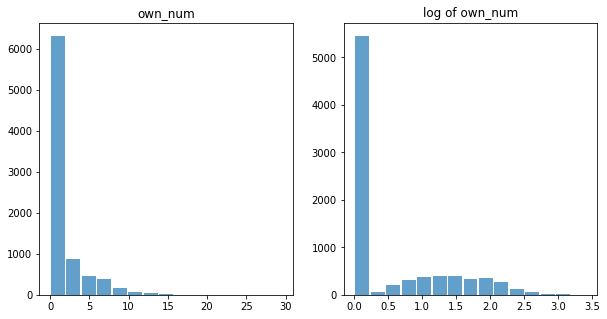

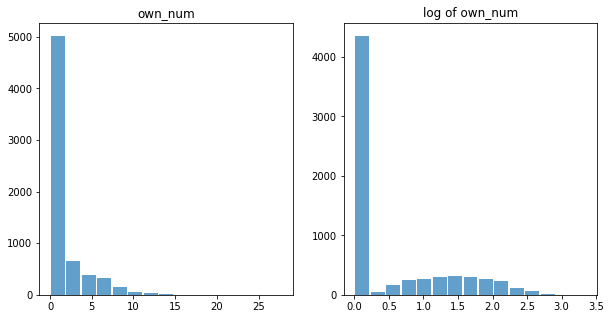

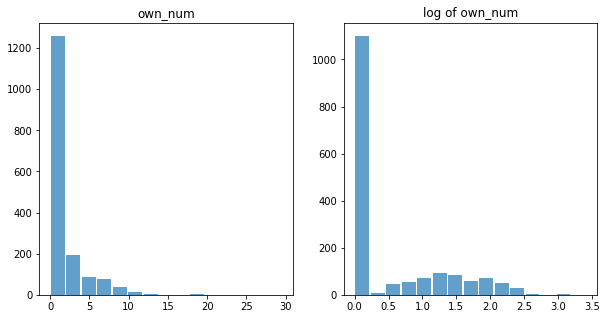

In [86]:
# Посмотрим на влияние логарифма 
val_log_plot(df, 'own_num')
val_log_plot(df[df['sample']==1], 'own_num')
val_log_plot(df[df['sample']==0], 'own_num')

Если не считать новые автомобили, которыми никто не владел, то остальные распределены лучше в логарифмическом виде.

In [87]:
# Логарифмируем
df['own_num_log'] = np.log(df['own_num']+1)

### name

In [88]:
print(df.name.unique())

['300 3.0 AT (220 л.с.)' '640d xDrive 3.0d AT (313 л.с.) 4WD'
 '325xi 2.5 AT (218 л.с.) 4WD' '318i 2.0 AT (136 л.с.)'
 '520d xDrive 2.0d AT (190 л.с.) 4WD' '540i xDrive 3.0 AT (340 л.с.) 4WD'
 '3.0d AT (245 л.с.) 4WD' '350 3.5 AT (316 л.с.)' '1.8 CVT (170 л.с.)'
 '1.8 CVT (160 л.с.)' '300 3.0 AT (231 л.с.)' '320i 2.2 AT (170 л.с.)'
 '500 5.5 AT (388 л.с.) 4WD' '2.0 CVT (180 л.с.)' '650i 4.8 AT (367 л.с.)'
 '116i 1.6 AT (115 л.с.)' '320i 2.0 AT (184 л.с.)'
 '25d 3.0d AT (218 л.с.) 4WD' '20d 2.0d AT (177 л.с.) 4WD'
 '500 4.7 AT (455 л.с.) 4WD' '330i 3.0 AT (231 л.с.)' '1.8 AMT (190 л.с.)'
 '500 4x4 4.0 AT (422 л.с.) 4WD' '200 2.0 AT (184 л.с.) 4WD'
 '1.8 CVT (163 л.с.)' '320d 2.0d AT (163 л.с.)' '118i 1.5 AT (136 л.с.)'
 '30d 3.0d AT (249 л.с.) 4WD' '630i 3.0 AT (272 л.с.)'
 '2.4 CVT (177 л.с.)' '318i 1.5 AT (136 л.с.)'
 '320 3.0d AT (224 л.с.) 4WD' '2.0 AMT (249 л.с.) 4WD'
 '1.4 AMT (122 л.с.)' '200 CDI 2.1d AMT (136 л.с.) 4WD'
 '320i xDrive 2.0 AT (184 л.с.) 4WD' '428i xDrive 2.0 AT (2

In [89]:
df.name = df.name.apply(set_lower)

In [90]:
print(len(df[df.name.str.contains('drive')]))
print(len(df[df.name.str.contains('blue')]))
print(len(df[df.name.str.contains('competition')]))
print(len(df[df.name.str.contains('hyb')]))
print(len(df[(df.name.str.contains('long')) | (df.name.str.contains('длинн'))]))
print(len(df[(df.name.str.contains('compact')) | (df.name.str.contains('компакт'))]))
print(len(df[df.name.str.contains('tronic')]))
print(len(df[df.name.str.contains('speed')]))
print(len(df[df.name.str.contains('tfsi')]))

948
163
25
14
360
10
44
3
31


Наделаем новых признаков, которые встречаются у большого количества автомобилей.

In [91]:
df['drive'] = df['name'].apply(lambda x: 1 if 'drive' in x else 0)
df['blue'] = df['name'].apply(lambda x: 1 if ('blue' in x or 'clean' in x) else 0)
df['long'] = df['name'].apply(lambda x: 1 if ('long' in x or 'длин' in x) else 0)

### description

In [92]:
# Сделаем первичную обработку
df['description'] = df['description'].apply(set_None)
df['description'] = df['description'].apply(set_lower)

# Заменим None на пустую строку
df['description'] = df['description'].apply(lambda x: '' if x is None else x)

# Заменим перевод строки '\n' и лишние знаки на ' '
intab = '.,;:!?-•–/+"☑️✔➥●☛✅ё' 
outtab = '                   е' 
trantab = str.maketrans(intab, outtab)
df['description'] = df['description'].apply(lambda x: x.replace('\n', ' '))
df['description'] = df['description'].apply(lambda x: x.translate(trantab))
df['description'] = df['description'].apply(lambda x: x.replace('\uf043\t', ' '))
df['description'] = df['description'].apply(lambda x: x.replace('\uf0fe\t', ' ').replace('  ', ' '))
df['description'] = df['description'].apply(lambda x: re.sub('\w*\d\w*', '', x))

In [93]:
df['description'][4668]

'bmw   мотор  акпп (для тех кто в теме) продам отличный автомобиль бизнес класса двигатель полностью обслужен работает как часы масло не ест едет очень бодро коробка переключает плавно в любых режимах по ходовой все в норме не гремит не стучит электроника работает абсолютна вся  каждая кнопочка кандей заправлен ошибок нет парктроники отлично выполняют свою функцию кузов отличный есть несколько косметических окрасов( вторичный окрас ) ржавчины нету пороги родные не варенные не ржавые  салон комфорт черная кожа безумно удобный управлять одно удовольствие много настроек сидений с памятью подогрев передних кресел отличная шумо изоляция музыка штатная звук отличный играет очень достойно птс оригинал я  хозяин места еще есть в общем отличный бумер автосалоны просьба не беспокоить возможно обмен с доплатой в обе стороны торг у капота '

In [94]:
# Выясним тональность отзыва и добавим в качестве фичи
from textblob import TextBlob
df['desc_polarity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['desc_polarity'].value_counts()

 0.000000    7547
 0.400000      82
 0.100000      78
 0.214286      70
-0.166667      34
             ... 
 0.246667       1
 0.095892       1
-0.055556       1
 0.190000       1
 0.056061       1
Name: desc_polarity, Length: 247, dtype: int64

In [95]:
df['desc_subjectivity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['desc_subjectivity'].value_counts()

0.000000    7478
0.100000      93
0.400000      79
0.642857      68
0.800000      59
            ... 
0.680000       1
0.540000       1
0.708333       1
0.347333       1
0.733333       1
Name: desc_subjectivity, Length: 221, dtype: int64

In [96]:
# Добавим столбец с длиной описания
df['desc_len'] = df.description.apply(lambda x: 0 if pd.isna(x) else len(x))

In [97]:
# Построим разреженные матрицы слов и создадим новые признаки: 
#   среднее значение (наполненность матрицы) и количество существенных слов
stopwords=nltk.corpus.stopwords.words('russian')
newStopWords = ['автомобиль','автомобилей', 'автомобиля', 'продаю', 'пробег', 'машина']
stopwords.extend(newStopWords)

vectorizer = CountVectorizer(stop_words=stopwords)

text_feat = vectorizer.fit_transform(df['description'])
df['desc_mean'] = text_feat.mean(axis=1)*1000
df['desc_sum'] = text_feat.sum(axis=1)

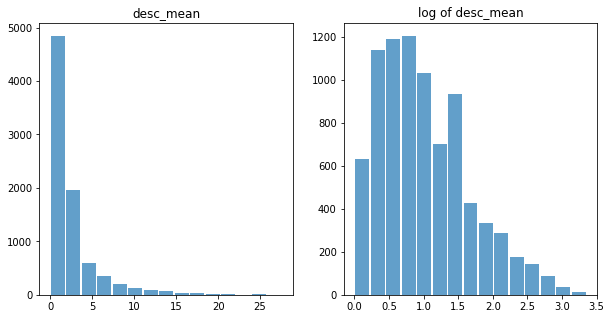

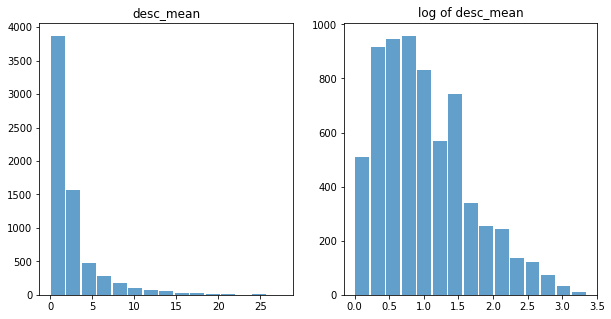

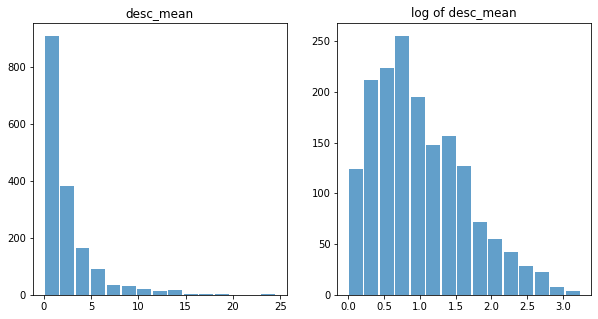

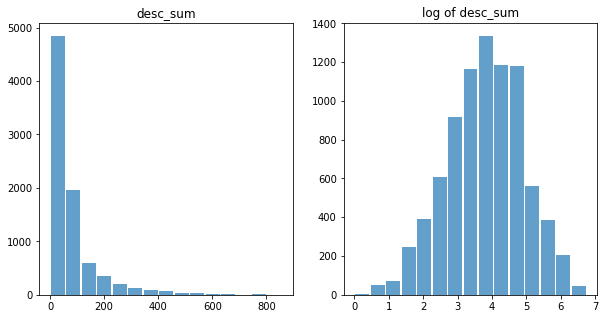

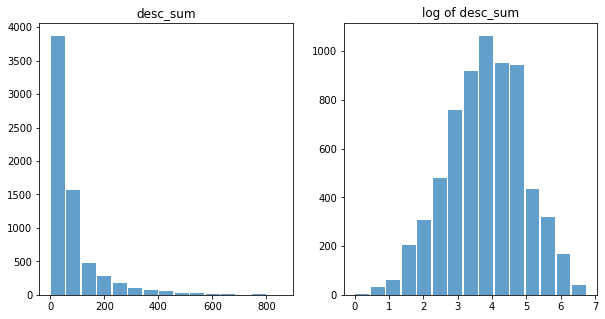

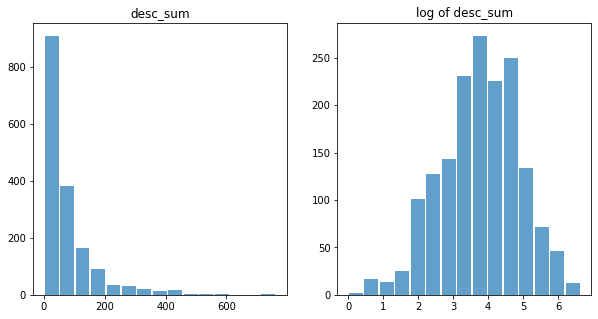

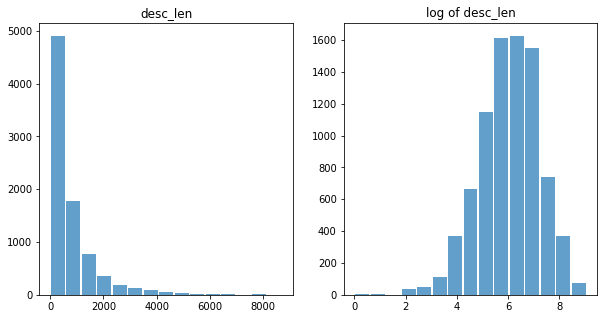

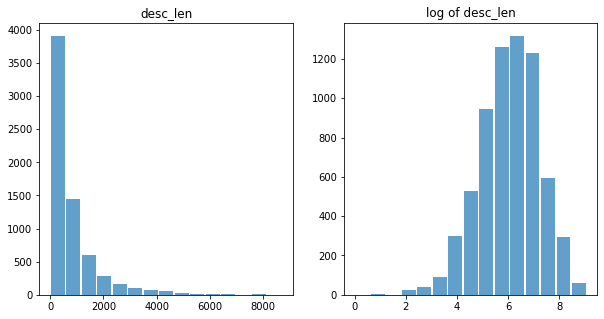

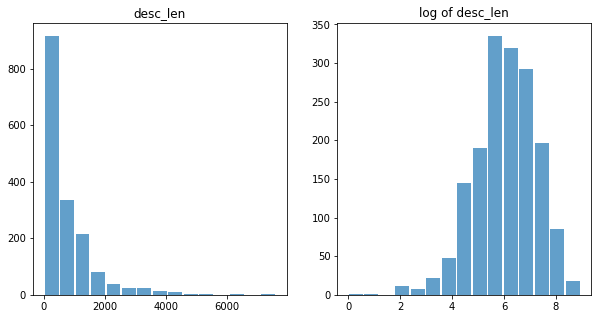

In [98]:
# Посмотрим на влияние логарифма на количество слов в описании
val_log_plot(df, 'desc_mean')
val_log_plot(df[df['sample']==1], 'desc_mean')
val_log_plot(df[df['sample']==0], 'desc_mean')

val_log_plot(df, 'desc_sum')
val_log_plot(df[df['sample']==1], 'desc_sum')
val_log_plot(df[df['sample']==0], 'desc_sum')

val_log_plot(df, 'desc_len')
val_log_plot(df[df['sample']==1], 'desc_len')
val_log_plot(df[df['sample']==0], 'desc_len')

Распределение всех величин при логарифмировании становится более похожим на нормальное. Заменим все величины логарифмом.

In [99]:
df['desc_mean_log'] = np.log(df['desc_mean'] + 1)
df['desc_sum_log'] = np.log(df['desc_sum'] + 1)
df['desc_len_log'] = np.log(df['desc_len'] + 1)

In [100]:
# Разбираем на слова признак 'description'
description = df['description'].copy(deep=True)
tokenizer = CountVectorizer(stop_words=stopwords).build_analyzer()
tokenized_text_feature = description.apply(tokenizer)

# Создаем разреженную матрицу слов
tf_idf = TfidfVectorizer(max_features=50, stop_words=stopwords)
tf_idf_feature = tf_idf.fit_transform(description).toarray()

# Уменьшаем до 2 размерность матрицы слов
pca = PCA(n_components=2, random_state=0)
tf_idf_pc = pca.fit_transform(tf_idf_feature)
df_tfidf = pd.DataFrame(tf_idf_pc, columns=['tfidf1', 'tfidf2'])

# Добавляем к данным матрицу слов со сниженной размерностью
df = pd.concat([df, df_tfidf], axis=1)
df[['tfidf1', 'tfidf2']]

,tfidf1,tfidf2
0,0.130328,-0.258778
1,-0.212305,0.079620
2,-0.002350,-0.150357
3,-0.359738,0.052444
4,0.058311,-0.125963
...,...,...
8348,-0.173300,-0.139285
8349,-0.062585,-0.113090
8350,-0.213314,0.020177
8351,-0.359772,0.114507


In [101]:
# Извлекаем дополнительные признаки
df['exState'] = df.description.apply(lambda x: 1 if re.search(r'отличн.+состоян+',x) else 0)
df['goodState'] = df.description.apply(lambda x: 1 if re.search(r'хорош.+состоян+',x) else 0)
df['noSmoke'] = df.description.apply(lambda x: 1 if 'прокур' in x or 'курил' in x else 0)
df['dent']= df.description.apply(lambda x: 1 if 'вмят' in x or 'царап' in x or 'трещ' in x or 'тресн' in x else 0)
df['salon']= df.description.apply(lambda x: 1 if 'дилер' in x or 'ликвидац' in x or 'кредит' in x \
                                      or 'юридич' in x or 'traide' in x or 'трейд' in x or 'официал' in x else 0)
df['carter'] = df.description.apply(lambda x: 1 if re.search(r'защит.+картер+',x) else 0)

df['electro-window'] = df.description.apply(lambda x: 1 if 'электростеклоподъемник' in x else 0)
df['airbag'] = df.description.apply(lambda x: 1 if re.search(r'подушк', x) else 0)
df['wheel-power'] = df.description.apply(lambda x: 1 if re.search(r'усилител', x) and re.search(r'руля', x) else 0)
df['lock'] = df.description.apply(lambda x: 1 if re.search(r'центральн.+зам+',x) else 0)
df['help'] = df.description.apply(lambda x: 1 if re.search(r'систем.+помощ+',x) else 0)
df['climate'] = df.description.apply(lambda x: 1 if 'климат' in x else 0)
df['cruise'] = df.description.apply(lambda x: 1 if 'круиз' in x else 0)
df['computer'] = df.description.apply(lambda x: 1 if re.search(r'бортов.+компьютер+',x) else 0)
df['heat'] = df.description.apply(lambda x: 1 if 'подогрев' in x else 0)
df['electro-mirrors'] = df.description.apply(lambda x: 1 if 'электропривод зеркал' in x else 0)
df['ptf'] = df.description.apply(lambda x: 1 if 'противотуман' in x else 0)
df['abs'] = df.description.apply(lambda x: 1 if 'антиблокировочн' in x or 'abs' in x or 'абс' in x else 0)
df['esp'] = df.description.apply(lambda x: 1 if 'курсовой устойчивости' in x or 'esp' in x else 0)
df['condition'] = df.description.apply(lambda x: 1 if 'кондиционер' in x else 0)
df['immo'] = df.description.apply(lambda x: 1 if 'иммобил' in x else 0)
df['alarm'] = df.description.apply(lambda x: 1 if 'сигнализ' in x else 0)
df['navigation'] = df.description.apply(lambda x: 1 if 'навига' in x else 0)
df['park'] = df.description.apply(lambda x: 1 if 'парк' in x else 0)
df['audio'] = df.description.apply(lambda x: 1 if 'audio' in x or 'аудио' in x else 0)
df['rain-sensor'] = df.description.apply(lambda x: 1 if re.search(r'датчик.+дождя+',x) else 0)
df['alloy-wheel-disks'] = df.description.apply(lambda x: 1 if re.search(r'легкосплавн',x) else 0)
df['camera'] = df.description.apply(lambda x: 1 if 'камера' in x else 0)
df['tyre-pressure'] = df.description.apply(lambda x: 1 if 'в шинах' in x else 0)
df['halogen'] = df.description.apply(lambda x: 1 if 'галоген' in x else 0)
df['dark'] = df.description.apply(lambda x: 1 if re.search(r'темн.+салон+',x) or re.search(r'черн.+салон+',x) else 0)
df['asr'] = df.description.apply(lambda x: 1 if 'антипробуксов' in x or 'asr' in x else 0)

# Анализ значимости признаков

In [102]:
df.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price', 'price_log', 'body', 'color_type', 'tax_rate',
       'eP_log', 'eP_log_out', 'eD_log', 'eD_log_out', 'mileage_out',
       'mileage_norm', 'mileage_norm_log', 'milPerYear', 'model_age',
       'model_age_log', 'age', 'age_log', 'model_old', 'model_old_log',
       'own_num', 'own_num_log', 'drive', 'blue', 'long', 'desc_polarity',
       'desc_subjectivity', 'desc_len', 'desc_mean', 'desc_sum',
       'desc_mean_log', 'desc_sum_log', 'desc_len_log', 'tfidf1', 'tfidf2',
       'exState', 'goodState', 'noSmoke', 'dent', 'salon', 'carter',
       'electro-window', 'airbag', 'wheel-power', 'lock', 'help', 'climate',
       'cruise', 'computer', 'heat', 'elec

In [103]:
# Двоичные признаки 
bin_columns = ['ПТС', 'Руль', 'color_type',
       'eP_log_out', 'eD_log_out', 'mileage_out',
       'drive', 'blue', 'long', 
       'exState', 'goodState', 'noSmoke', 'dent', 'salon', 'carter',
       'electro-window', 'airbag', 'wheel-power', 'lock', 'help', 'climate',
       'cruise', 'computer', 'heat', 'electro-mirrors', 'ptf', 'abs', 'esp',
       'condition', 'immo', 'alarm', 'navigation', 'park', 'audio',
       'rain-sensor', 'alloy-wheel-disks', 'camera', 'tyre-pressure',
       'halogen', 'dark', 'asr']

# Числовые признаки
num_columns = ['Владельцы','tax_rate','eP_log', 'eD_log', 
       'mileage_norm_log', 'milPerYear', 'model_age_log', 'age_log', 'model_old_log',
       'own_num_log', 'desc_polarity', 'desc_subjectivity', 
       'desc_mean_log', 'desc_sum_log', 'desc_len_log', 'tfidf1', 'tfidf2']

# Категориальные признаки
cat_columns = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 
       'numberOfDoors', 'vehicleTransmission', 'body']

# Служебные признаки
srv_columns = ['price', 'price_log', 'sample', 'sell_id']

In [104]:
# Проверку значимости будем делать на копии подготовленного датасета
data = df.copy()

In [105]:
# Собираем столбцы и кодируем категориальные переменные.
# Для нейронной сети будем применять One-Hot-Coding.
# Здесь, для проверки значимости, воспользуемся более простым кодером.
columns = bin_columns + num_columns + cat_columns +srv_columns
for colum in cat_columns:
    data[colum] = data[colum].astype('category').cat.codes

<AxesSubplot:>

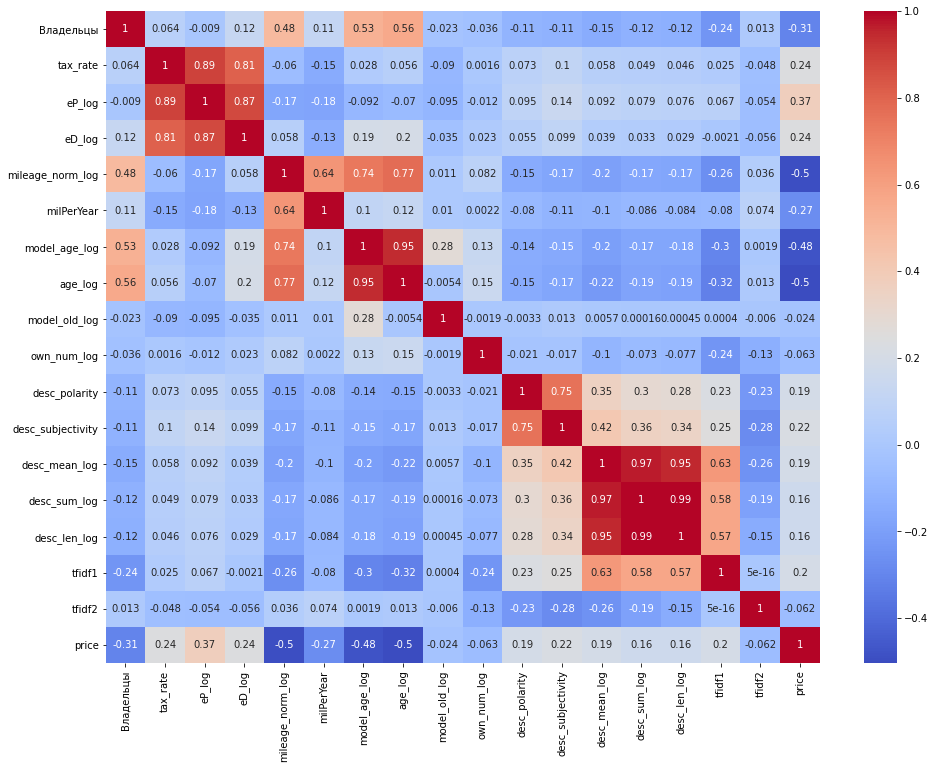

In [106]:
# Проверим корреляцию числовых столбцов в сборном датасете
correlation = data[num_columns+['price']].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Столбцы desc_mean_log, desc_len_log, desc_sum_log сильно коррелируют. Уберем из признаков для модели desc_sum_log. Все остальные столбцы оставим, даже с корреляцией 0.95. Опыт показывает, что удаление ниже такого коэффициента уменьшает метрику.

In [107]:
# Проверим статистическую значимость числовых столбцов по Пирсону
get_stat_corr(data[data.price>0], num_columns, 'price_log')

Владельцы для price_log - значимость есть
tax_rate для price_log - значимость есть
eP_log для price_log - значимость есть
eD_log для price_log - значимость есть
mileage_norm_log для price_log - значимость есть
milPerYear для price_log - значимость есть
model_age_log для price_log - значимость есть
age_log для price_log - значимость есть
model_old_log для price_log - значимость есть
own_num_log для price_log - значимость есть
desc_polarity для price_log - значимость есть
desc_subjectivity для price_log - значимость есть
desc_mean_log для price_log - значимость есть
desc_sum_log для price_log - значимость есть
desc_len_log для price_log - значимость есть
tfidf1 для price_log - значимость есть
tfidf2 для price_log - значимость есть


Все числовые столбцы значимы для цены.

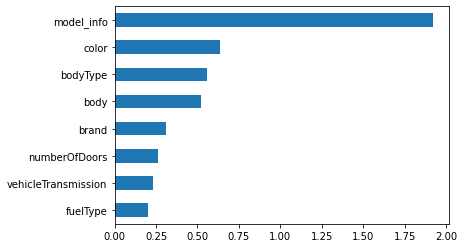

In [108]:
# Посмотрим на значимость категориальных столбцов
df1 = data[data.price>0][columns].copy()

label_encoder = LabelEncoder()
for col in cat_columns:
    df1[col] = label_encoder.fit_transform(df1[col])
    
imp_cat = pd.Series(mutual_info_classif(df1[cat_columns], 
                                        df1['price'], discrete_features = True), 
                    index=cat_columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

plt.show()

Все категориальные столбцы тоже значимы.

In [109]:
# Проверим значимость признаков с дискретными значениями по критерию Стьюдента
get_stat_dif(df1, cat_columns, 'price_log')

bodyType: порог=0.000368, значимость есть: для (12, 1) p_value=1.3774424155527512e-60
brand: порог=0.016667, значимость есть: для (1, 2) p_value=1.7991274747960808e-55
color: порог=0.000417, значимости нет
fuelType: порог=0.008333, значимость есть: для (0, 2) p_value=4.095414349689026e-84
model_info: порог=7e-06, значимость есть: для (7, 5) p_value=9.072171846895634e-12
numberOfDoors: порог=0.008333, значимость есть: для (3, 2) p_value=8.710436426341588e-31
vehicleTransmission: порог=0.008333, значимость есть: для (0, 2) p_value=0.00014046744561857326
body: порог=0.000758, значимость есть: для (9, 0) p_value=1.567891932677766e-60


Этот тест показал, что цвет не влияет на цену. Но так как предыдущий тест дал этому признаку второе место по значимости, все-таки оставим.

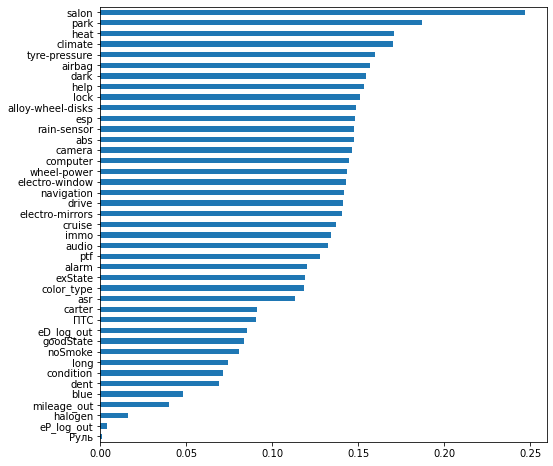

In [110]:
# Проверим значимость двоичных признаков
imp_cat = pd.Series(mutual_info_classif(df1[bin_columns], 
                                        df1['price'], discrete_features = True), 
                    index=bin_columns)
imp_cat.sort_values(inplace = True)
plt.figure(figsize=(8, 8)) 
imp_cat.plot(kind = 'barh')
plt.show()

Исключим последние по значимости признаки (меньше 0.05). Это Руль, eP_log_out, halogen, mileage_out, blue.

In [111]:
# Собираем столбцы, которые показали значимость

# Двоичные признаки 
bin_columns = ['ПТС', 'color_type','eD_log_out', 'drive', 'long', 
       'exState', 'goodState', 'noSmoke', 'dent', 'salon', 'carter',
       'electro-window', 'airbag', 'wheel-power', 'lock', 'help', 'climate',
       'cruise', 'computer', 'heat', 'electro-mirrors', 'ptf', 'abs', 'esp',
       'condition', 'immo', 'alarm', 'navigation', 'park', 'audio',
       'rain-sensor', 'alloy-wheel-disks', 'camera', 'tyre-pressure',
       'dark', 'asr']

# Числовые признаки
num_columns = ['Владельцы','tax_rate','eP_log', 'eD_log', 
       'mileage_norm_log', 'milPerYear', 'model_age_log', 'age_log', 'model_old_log',
       'own_num_log', 'desc_polarity', 'desc_subjectivity', 
       'desc_mean_log', 'desc_len_log', 'tfidf1', 'tfidf2']

# Категориальные признаки
cat_columns = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 
       'numberOfDoors', 'vehicleTransmission', 'body']

# Служебные признаки
srv_columns = ['price', 'sample', 'sell_id']

# Добавление столбцов со статистикой

Добавим столбцы со статистиками по важным категориям (бренд, модель, кузов, привод, трансмиссия, топливо) + 
и важным двоичным признакам для самых важных числовых признаков.    
Важность признаков определили по результатам корреляционного анализа.    
    
Статистику возьмем только по автомобилям с пробегом

In [112]:
df0 = df[df.mileage>0]

num_feature = ['price', 'eP_log', 'eD_log', 
        'mileage_norm_log', 'milPerYear', 'model_age_log', 'age_log']
cat_feature = ['model_info','bodyType', 'brand', 'color', 'fuelType',  
       'numberOfDoors', 'vehicleTransmission', 'body'] 

In [113]:
new_columns = []

for nf in num_feature:
    for cf in cat_feature:
        if nf=='price':
            mean_nf = df0[df0['sample']==1][nf].mean()
            median_nf = df0[df0['sample']==1][nf].median()
            max_nf = df0[df0['sample']==1][nf].max()
            min_nf = df0[df0['sample']==1][nf].min()
            std_nf = df0[df0['sample']==1][nf].std()
        else:
            mean_nf = df0[nf].mean()
            median_nf = df0[nf].median()
            max_nf = df0[nf].max()
            min_nf = df0[nf].min()
            std_nf = df0[nf].std()
        
        # Среднее
        match = dict(df.groupby(cf)[nf].mean())
        df['mean_'+cf+'_'+nf] = np.log(df[cf].apply(lambda x: match[x] if x in match else mean_nf )+1)
        df['mean_'+cf+'_'+nf] = df['mean_'+cf+'_'+nf].fillna(mean_nf)
        new_columns.append('mean_'+cf+'_'+nf)
        
        # Медиана
        match = dict(df.groupby(cf)[nf].median())
        df['median_'+cf+'_'+nf] = np.log(df[cf].apply(lambda x: match[x] if x in match else median_nf )+1)
        df['median_'+cf+'_'+nf] = df['median_'+cf+'_'+nf].fillna(median_nf)
        new_columns.append('median_'+cf+'_'+nf)
                
        # Максимум
        match = dict(df.groupby(cf)[nf].max())
        df['max_'+cf+'_'+nf] = np.log(df[cf].apply(lambda x: match[x] if x in match else max_nf )+1)
        df['max_'+cf+'_'+nf] = df['max_'+cf+'_'+nf].fillna(max_nf)
        new_columns.append('max_'+cf+'_'+nf)
        
        # Минимум
        match = dict(df.groupby(cf)[nf].min())
        df['min_'+cf+'_'+nf] = np.log(df[cf].apply(lambda x: match[x] if x in match else min_nf )+1)
        df['min_'+cf+'_'+nf] = df['min_'+cf+'_'+nf].fillna(min_nf)
        new_columns.append('min_'+cf+'_'+nf)
        
        # Разброс
        match = dict(df.groupby(cf)[nf].std())
        df['std_'+cf+'_'+nf] = np.log(df[cf].apply(lambda x: match[x] if x in match else std_nf )+1)
        df['std_'+cf+'_'+nf] = df['std_'+cf+'_'+nf].fillna(std_nf)
        new_columns.append('std_'+cf+'_'+nf)

In [114]:
columns = bin_columns + num_columns + cat_columns + srv_columns + new_columns
columns1 = bin_columns + num_columns + cat_columns + srv_columns
columns2 = srv_columns + new_columns

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 368 entries, bodyType to std_body_age_log
dtypes: float64(301), int64(55), object(12)
memory usage: 23.5+ MB


# Сохранение

Сохраним обработанный дадасет и список значимых столбцов.

In [116]:
df[columns1].to_csv('df_clean1.csv')
df[columns2].to_csv('df_clean2.csv')

In [117]:
# columns = bin_columns + num_columns + cat_columns + srv_columns

In [118]:
with open('best_columns', 'w') as f:
    f.write("\n".join(columns))

In [119]:
# Пример чтения
# with open('./best_columns', 'r') as f:
#     mystring = f.read()
# my_list = mystring.split("\n")

# Подбор моделей

### Подготовка данных

In [120]:
data = df[columns].copy()
data = pd.get_dummies(data, columns=cat_columns, dummy_na=False)

In [121]:
X = data[data['sample'] == 1].drop(['sample','price','sell_id'], axis=1)
X_sub = data[data['sample'] == 0].drop(['sample','price','sell_id'], axis=1)
y = data[data['sample'] == 1]['price']
X.shape, len(y)

((6682, 513), 6682)

In [122]:
# Разбиваем тренировочный набор для обучения
VAL_SIZE = 0.2
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### RandomForest

In [123]:
# Модель с параметрами по умолчанию на старых данных
model1 = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model1.fit(X_train, np.log(y_train))
y_pred1 = model1.predict(X_test)

# Преобразуем y_test, y_pred к exp значениям для оценки MAPE

y_pred1 = np.round(np.exp(y_pred1))

# Вывод результата MAPE
print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred1))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 11.67%


# CatBoost

In [124]:
model2 = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model2.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

# Непонятно, зачем это. Надо почитать.
# model2.save_model('catboost_single_model_2_baseline.model')

y_pred2 = np.exp(model2.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred2))*100:0.2f}%")

Точность модели по метрике MAPE: 11.16%


In [125]:
# Модель с параметрами по умолчанию 
model3 = GradientBoostingRegressor(random_state=RANDOM_SEED) 

# Обучаем модель на тестовом наборе данных
model3.fit(X_train, np.log(y_train))
y_pred3 = model3.predict(X_test)

# Преобразуем y_test, y_pred к exp значениям для оценки MAPE 

y_pred3 = np.round(np.exp(y_pred3))

# Вывод результата MAPE 
print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred3))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 12.89%


In [126]:
# Модель с параметрами по умолчанию
model4 = xgb.XGBRegressor()
model4.fit(X_train, np.log(y_train))

y_pred4 = np.exp(model4.predict(X_test))

# Вывод результата MAPE
print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred4))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 12.30%


In [127]:
y_pred = 0.33*y_pred1 + 0.67*y_pred2
print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 10.86%


# Submission

In [128]:
predict_submission1 = np.exp(model1.predict(X_sub))
predict_submission2 = np.exp(model2.predict(X_sub))
predict_submission = (predict_submission1 + predict_submission2)/2

sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_ml.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1099427284,6.178475e+05
1,1096405886,2.558702e+06
2,1100195294,6.886188e+05
3,1099827282,4.853910e+05
4,1100076198,2.721333e+06
5,1090159352,2.996060e+06
6,1098987386,1.536416e+06
7,1098639040,1.432514e+06
8,1099933039,1.135744e+06
9,1099565572,5.154759e+05
